In [ ]:
! pip install pymunk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch import Tensor
from torchvision import transforms
from PIL import Image, ImageDraw
from google.colab import drive
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import os
drive.mount('/content/drive')
base = '/content/drive/My Drive/CS 182 Final Project/data/'
path_to_folder = '/content/drive/My Drive/CS 182 Final Project'
os.chdir(path_to_folder)
from data_generation import *

Mounted at /content/drive


In [ ]:
def generate_single_sequence(args):
    return generate_random_sequence(**args)

class PixelDataset(Dataset):
    def __init__(self, num_sequences, sequence_length, **kwargs):
        self.data = []
        self.targets = []

        # Create a list of dictionaries, each containing the arguments for one sequence generation
        args_list = [
            {"sequence_length": sequence_length, **kwargs} for _ in range(num_sequences)
        ]

        # Parallel generation of sequences using joblib
        results = Parallel(n_jobs=-1)(
            delayed(generate_single_sequence)(args) for args in args_list
        )

        # Unpack results and populate data and targets
        for images, positions in results:
            self.data.append(images)
            self.targets.append(positions)

        self.transform = transforms.ToTensor()
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sequence_of_images = [self.transform(image) for image in self.data[idx]]
        sequence_of_images = torch.stack(sequence_of_images)
        target_positions = torch.FloatTensor(self.targets[idx])
        return sequence_of_images, target_positions

In [ ]:
dataset = torch.load(base + 'simple_dataset20k.pt')
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
H, W = 16, 16
L = 10
num_epochs = 5

[batch_size, sequence_length, 1, H, W] input flattened to [batch_size, sequence_length, H * W]

In [ ]:
N = 1000
batch_size = 32

In [ ]:
class PixelDataset(Dataset):
    def __init__(self, num_sequences, sequence_length):
        self.data = []
        self.targets = []
        for _ in range(num_sequences):
            images, positions = generate_random_sequence()
            self.data.append(images)  # Store the whole sequence
            self.targets.append(positions)  # Store all positions

        self.transform = transforms.ToTensor()
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Transform and stack images to create a sequence
        sequence_of_images = [self.transform(image) for image in self.data[idx]]
        sequence_of_images = torch.stack(sequence_of_images)

        # Stack target positions
        target_positions = torch.FloatTensor(self.targets[idx])

        return sequence_of_images, target_positions


# Creating Dataset and DataLoader
dataset = PixelDataset(N, L)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Using device: cuda


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/5], Loss: 4.0160
Epoch [2/5], Loss: 3.4345
Epoch [3/5], Loss: 3.4119
Epoch [4/5], Loss: 3.4021
Epoch [5/5], Loss: 3.3973


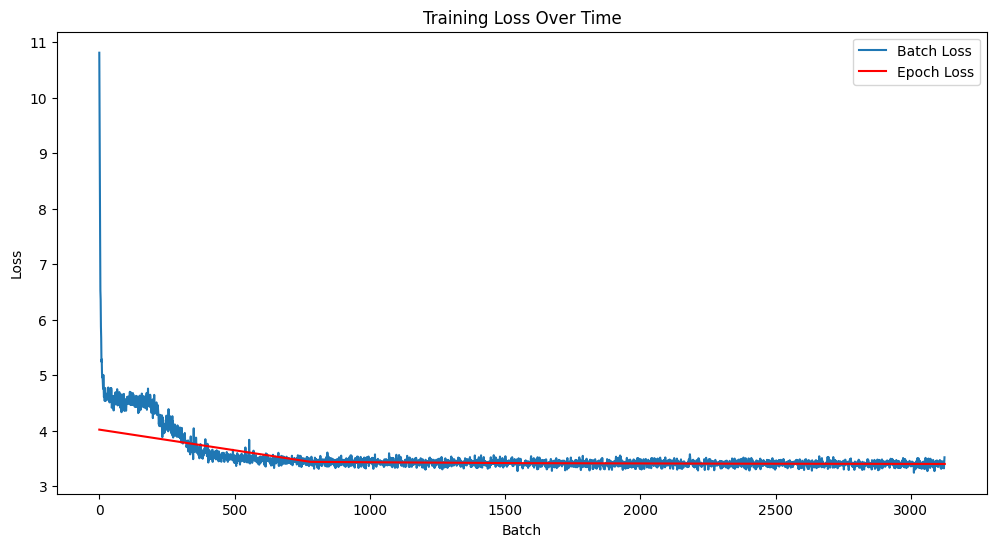

In [ ]:
class OldTransformer(nn.Module):
    def __init__(self):
        super(OldTransformer, self).__init__()
        self.encoder = nn.TransformerEncoderLayer(d_model=H * W, nhead=4)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder, num_layers=3)
        self.fc = nn.Linear(H * W, 2)  # Output is x, y position

    def forward(self, x):
        # Flatten the image and encode
        batch_size, sequence_length, _, _, _ = x.size()
        x = x.view(batch_size, sequence_length, -1)
        encoded = self.transformer_encoder(x)
        output = self.fc(encoded)  # Apply the linear layer to the entire sequence
        return output


def euclidean_distance_loss(output, target):
    epsilon = 1e-6  # A small constant to avoid sqrt(0)
    return torch.sqrt(torch.sum((output - target) ** 2, dim=-1) + epsilon).mean()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = OldTransformer().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = euclidean_distance_loss

# Lists to store losses
epoch_losses = []
batch_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for images, positions in dataloader:
        images = images.to(device)
        positions = positions.to(device)

        # Shift the positions by one to create the targets
        targets = torch.roll(positions, -1, dims=1)

        # Mask the last position in each sequence as it has no valid next position
        mask = torch.zeros_like(targets)
        mask[:, :-1, :] = 1  # Mask all but the last position

        # Forward pass
        predicted_positions = model(images)

        # Apply the mask
        masked_predicted = predicted_positions * mask
        masked_targets = targets * mask

        # Compute loss
        loss = criterion(masked_predicted, masked_targets)
        total_loss += loss.item()
        batch_losses.append(loss.item())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

    avg_epoch_loss = total_loss / len(dataloader)
    epoch_losses.append(avg_epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}")

# Plotting the loss
plt.figure(figsize=(12, 6))
plt.plot(batch_losses, label='Batch Loss')
plt.plot(np.linspace(0, len(batch_losses), len(epoch_losses)), epoch_losses, label='Epoch Loss', color='red')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        x = x + self.pe[:x.size(0), :]
        return x

In [ ]:
class SimpleTransformerWithPE(nn.Module):
    def __init__(self):
        super(SimpleTransformerWithPE, self).__init__()
        self.pe = PositionalEncoding(d_model = H*W)
        self.encoder = nn.TransformerEncoderLayer(d_model=H * W, nhead=4, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder, num_layers=3)
        self.fc = nn.Linear(H * W, 2)  # Output is x, y position

    def generate_causal_mask(self, size):
        """ Generate a square causal mask to mask out future positions.
            The mask will have shape [size, size] """
        mask = torch.triu(torch.ones(size, size), diagonal=1).bool()
        return mask


    def forward(self, x):
        batch_size, sequence_length, _, _, _ = x.size()  # Flatten the image and encode

        x = x.view(batch_size, sequence_length, -1)
        x = self.pe(x)
        mask = self.generate_causal_mask(sequence_length).to(x.device)
        encoded = self.transformer_encoder(x, mask=mask)
        output = self.fc(encoded)  # Apply the linear layer to the entire sequence
        return output

class SimpleTransformer(nn.Module):
    def __init__(self):
        super(SimpleTransformer, self).__init__()
        self.encoder = nn.TransformerEncoderLayer(d_model=H * W, nhead=4)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder, num_layers=3)
        self.fc = nn.Linear(H * W, 2)  # Output is x, y position

    def forward(self, x):
        # Flatten the image and encode
        batch_size, sequence_length, _, _, _ = x.size()

        x = x.view(batch_size, sequence_length, -1)
        encoded = self.transformer_encoder(x)
        output = self.fc(encoded)  # Apply the linear layer to the entire sequence
        return output

def euclidean_distance_loss(predictions, targets):
    squared_diff = (predictions - targets) ** 2
    loss_per_point = torch.sqrt(torch.sum(squared_diff, dim=-1) + 1e-6)  # Add a small epsilon to avoid sqrt(0)
    return loss_per_point.mean()

def manhattan_distance_loss(output, target):
    return torch.sum(torch.abs(output - target), dim=-1).mean()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model, Optimizer, and Loss
model = SimpleTransformerWithPE().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = euclidean_distance_loss

# Initialize lists to store loss values
epoch_losses = []

# Training loop
for epoch in range(num_epochs):
    batch_losses = []
    example_counter = 0

    for images, positions in dataloader:
        images, positions = images.to(device), positions.to(device)

        # Shift the positions by one to create the targets
        targets = torch.roll(positions, -1, dims=1).to(device)

        # Mask the last position in each sequence
        mask = torch.ones_like(targets).to(device)
        mask[:, 3:, :] = 0

        # Forward pass
        predicted_positions = model(images) # shape is B x L x 2

        # Apply the mask
        masked_predicted = predicted_positions * mask
        masked_targets = targets * mask

        # Compute loss and optimize
        loss = criterion(masked_predicted, masked_targets)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Record the loss for this batch
        batch_losses.append(loss.item())

        # Update example counter and print progress
        example_counter += len(images)
        if example_counter % 10000 == 0:
            print(f"Processed {example_counter} training examples in Epoch {epoch + 1}")

    # Compute average loss for the epoch
    epoch_loss = sum(batch_losses) / len(batch_losses)
    epoch_losses.append(epoch_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Loss: {epoch_loss:.4f}")


Using device: cuda
Epoch [1/30] completed, Average Loss: 1.6054
Epoch [2/30] completed, Average Loss: 1.4785
Epoch [3/30] completed, Average Loss: 1.4754
Epoch [4/30] completed, Average Loss: 1.4790
Epoch [5/30] completed, Average Loss: 1.4702
Epoch [6/30] completed, Average Loss: 1.4764
Epoch [7/30] completed, Average Loss: 1.4747
Epoch [8/30] completed, Average Loss: 1.4717
Epoch [9/30] completed, Average Loss: 1.4735
Epoch [10/30] completed, Average Loss: 1.4684
Epoch [11/30] completed, Average Loss: 1.4724
Epoch [12/30] completed, Average Loss: 1.4760
Epoch [13/30] completed, Average Loss: 1.4647
Epoch [14/30] completed, Average Loss: 1.4805
Epoch [15/30] completed, Average Loss: 1.4725
Epoch [16/30] completed, Average Loss: 1.4727
Epoch [17/30] completed, Average Loss: 1.4725
Epoch [18/30] completed, Average Loss: 1.4740
Epoch [19/30] completed, Average Loss: 1.4691
Epoch [20/30] completed, Average Loss: 1.4691
Epoch [21/30] completed, Average Loss: 1.4666
Epoch [22/30] completed,

In [ ]:
torch.save(model, 'models/old_model_on_simple_dataset20k.pt')

In [ ]:
# plt.plot(batch_losses)
# plt.xlabel('Epoch')
# plt.ylabel('Average Loss')
# plt.title('Training Loss Over Batches')
# plt.show()

plt.plot(epoch_losses)
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss Over Epochs')
plt.show()

NameError: ignored

In [ ]:
def predict_sequence(model, sequence_of_images, device):
    """
    Predict the positions for a given sequence of images.

    :param model: Trained PyTorch model.
    :param sequence_of_images: A sequence of images as a PyTorch tensor.
    :param device: Device to perform computations on (e.g., 'cuda', 'cpu').
    :return: Predicted positions as a tensor.
    """
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        sequence_of_images = sequence_of_images.to(device)
        predicted_positions = model(sequence_of_images)
    return predicted_positions.cpu()


def create_images_from_positions(positions, image_size=(16, 16)):
    """
    Create a sequence of PIL images from a sequence of position tuples.
    Includes an empty image at the beginning of the sequence.

    :param positions: A sequence of (x, y) tuples as a PyTorch tensor.
    :param image_size: Size of the output images (width, height).
    :return: A list of PIL.Image.Image objects.
    """
    images = []
    positions = positions.squeeze()
    if positions.dim() == 1:
        positions = positions.unsqueeze(0)

    # Create and add an empty image for the first position
    empty_img = Image.new("1", image_size, 255)  # White image
    images.append(empty_img)

    for pos in positions:
        img = Image.new("1", image_size, 255)  # Create a white image
        draw = ImageDraw.Draw(img)
        x, y = pos.tolist()
        y = image_size[1] - 1 - y  # Adjust y-coordinate
        draw.point((x, y), fill=0)  # Draw the black pixel
        images.append(img)

    return images


def prepare_sequence_for_model(image_sequence):
    """
    Prepare a sequence of PIL images for input into the model.

    :param image_sequence: A list of PIL.Image.Image objects.
    :return: A PyTorch tensor representing the sequence.
    """
    transform = transforms.Compose(
        [
            transforms.Grayscale(),  # Convert to grayscale if not already
            transforms.ToTensor(),  # Convert PIL Image to PyTorch tensor
        ]
    )

    tensor_sequence = [transform(img) for img in image_sequence]
    tensor_sequence = torch.stack(tensor_sequence)  # Stack to create a single tensor
    tensor_sequence = tensor_sequence.unsqueeze(0)  # Add a batch dimension

    return tensor_sequence


def overlay_predicted_positions(s1, s2):
    """
    s1 black pixels stay black
    s2 black pixels become blue

    :param s1: A list of PIL.Image.Image objects representing the original sequence.
    :param s2: A list of PIL.Image.Image objects representing the predicted sequence.
    :return: A list of PIL.Image.Image objects with overlaid positions.
    """
    overlaid_images = []
    for img1, img2 in zip(s1, s2):
        img1 = img1.convert("RGB")  # Convert to RGB
        img2 = img2.convert("RGB")

        # Create a new image for the overlay
        new_img = Image.new("RGB", img1.size)
        pixels1 = img1.load()
        pixels2 = img2.load()

        for x in range(img1.width):
            for y in range(img1.height):
                if pixels2[x, y] == (0, 0, 0):  # Black pixel in s2
                    new_img.putpixel((x, y), (0, 0, 255))  # Make it blue
                else:
                    new_img.putpixel((x, y), pixels1[x, y])  # Use pixel from s1

        overlaid_images.append(new_img)

    return overlaid_images

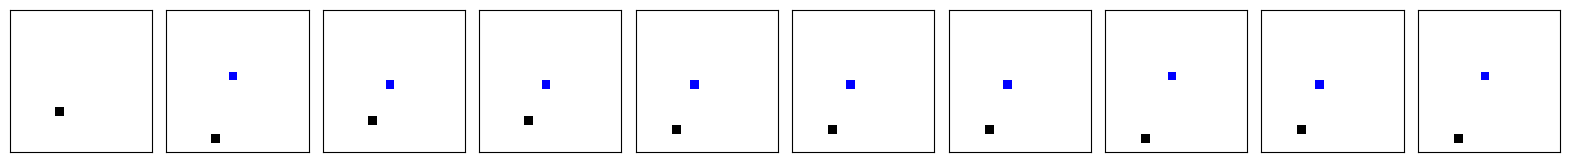

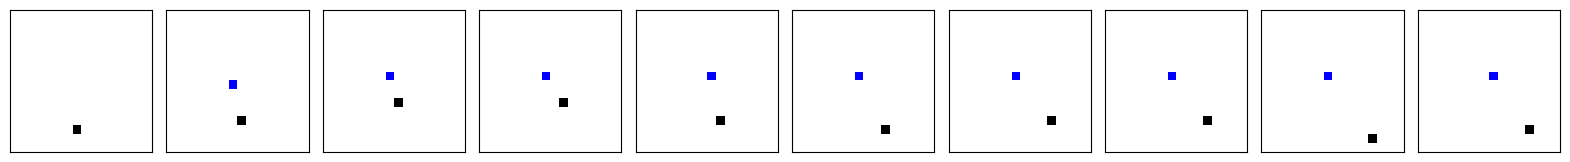

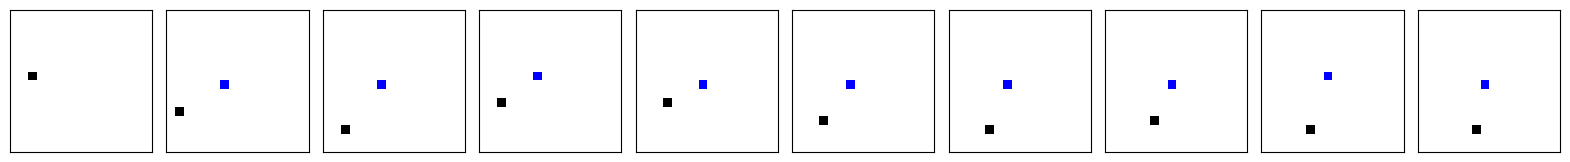

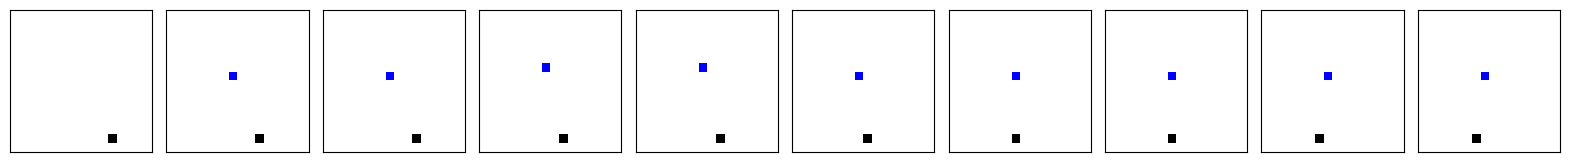

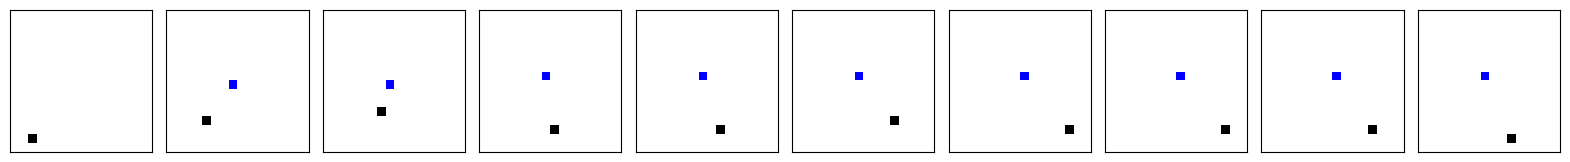

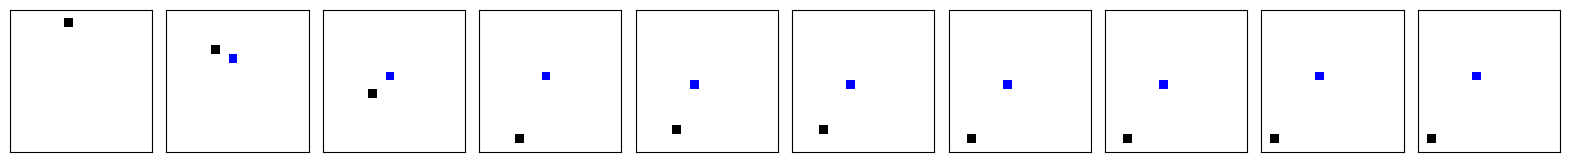

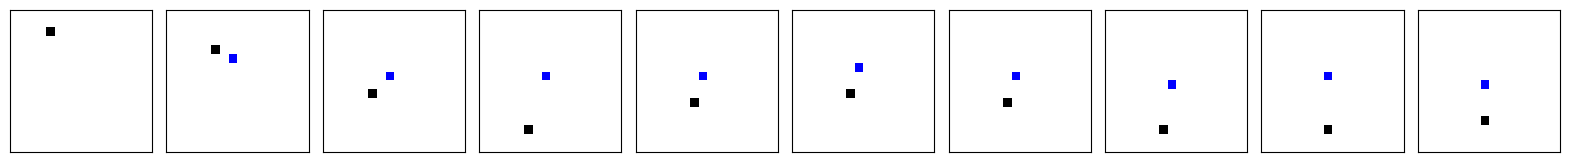

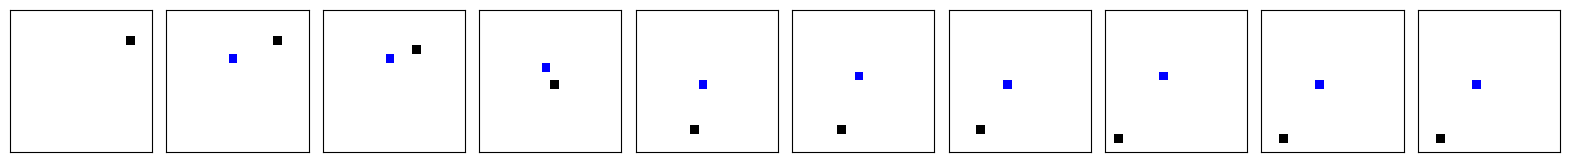

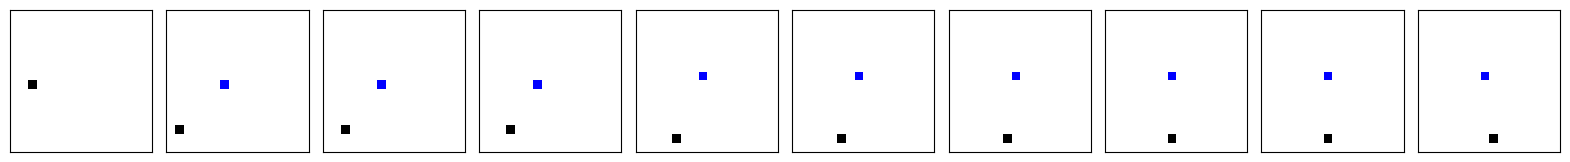

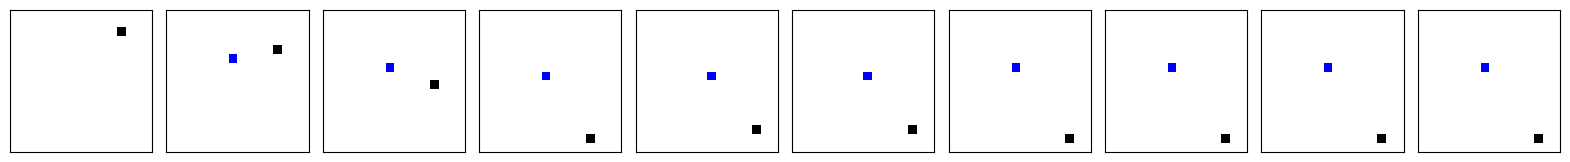

In [ ]:
for _ in range(10):
  sequence, positions = generate_random_sequence()
  sequence_of_images = prepare_sequence_for_model(sequence)
  predicted_positions = predict_sequence(
      model, sequence_of_images, device="cuda"
  )
  predicted_positions = predicted_positions[:, 1:, :]
  predicted_images = create_images_from_positions(predicted_positions)
  display_sequence(overlay_predicted_positions(sequence, predicted_images))

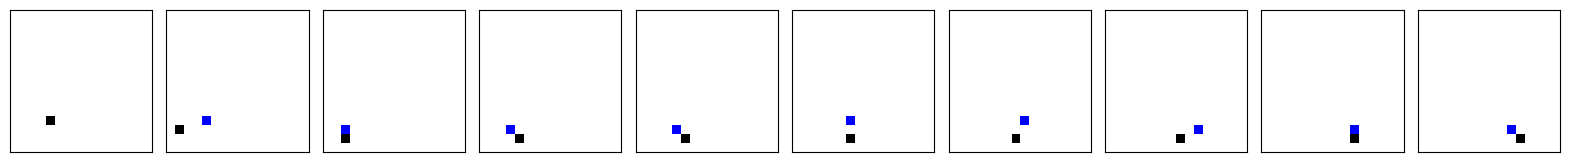

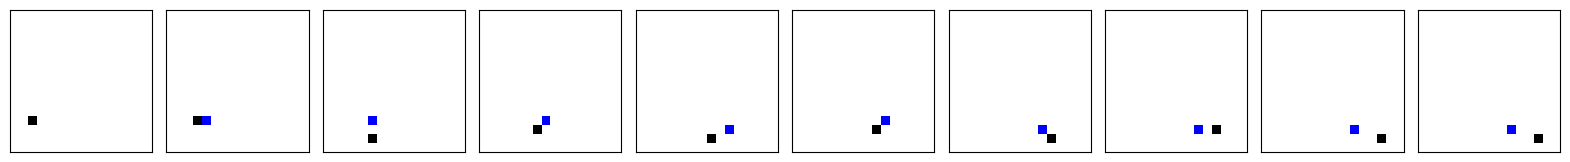

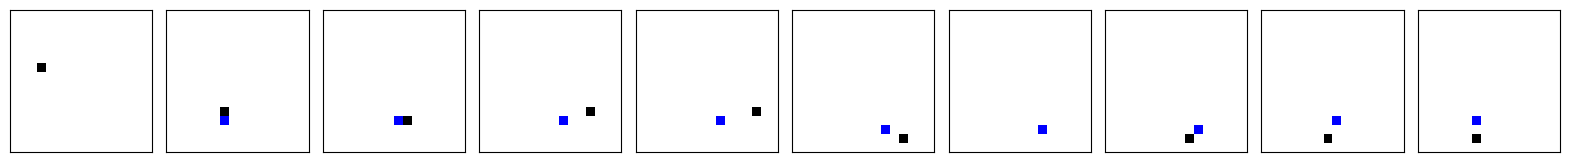

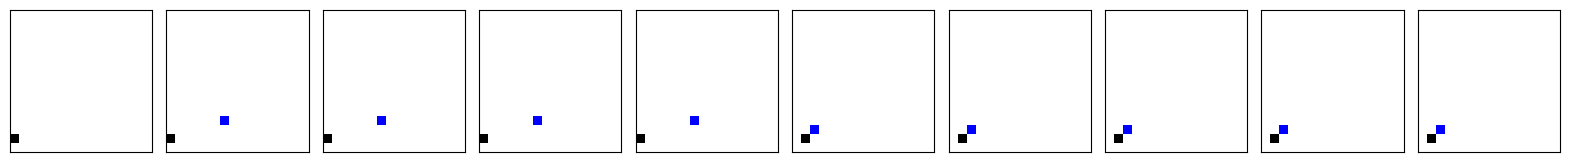

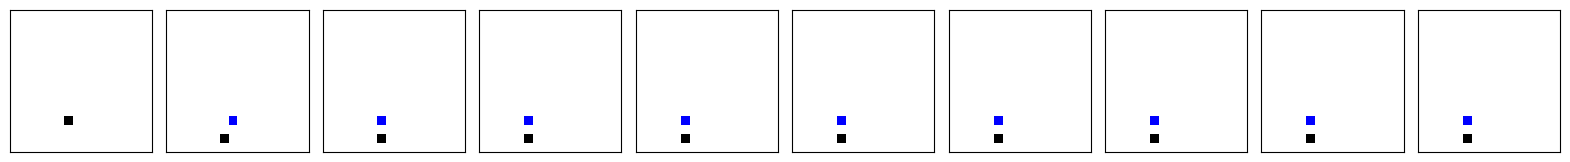

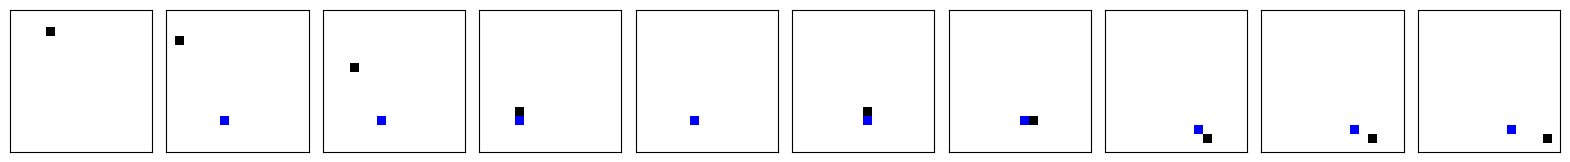

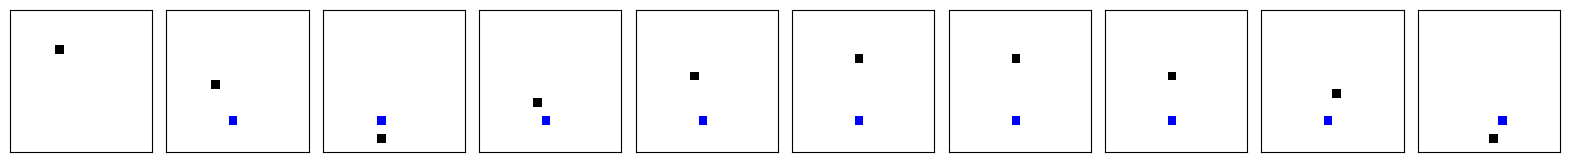

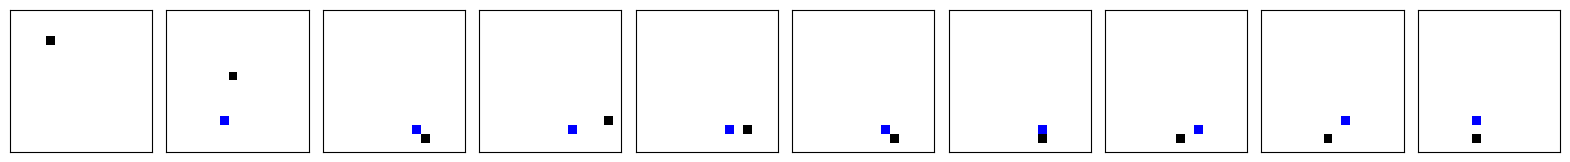

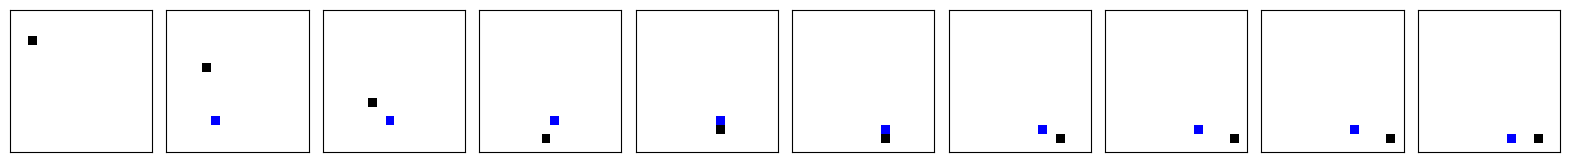

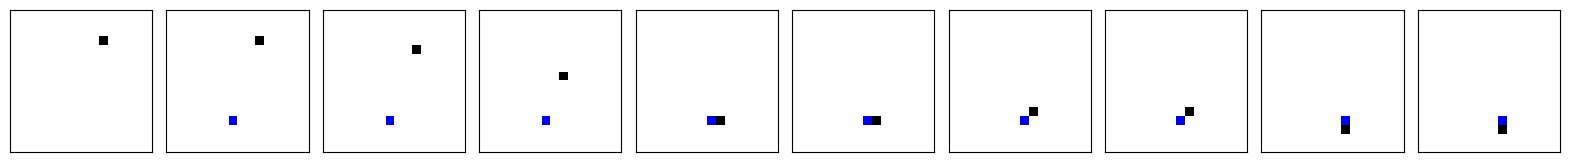

In [ ]:
for _ in range(10):
  sequence, positions = generate_random_sequence()
  sequence_of_images = prepare_sequence_for_model(sequence)
  predicted_positions = predict_sequence(
      model, sequence_of_images, device="cuda"
  )
  predicted_positions = predicted_positions[:, 1:, :]
  predicted_images = create_images_from_positions(predicted_positions)
  display_sequence(overlay_predicted_positions(sequence, predicted_images))